In [1]:
"""Take dreamcoder models from diff expts, (but overlapping behavior), and combine human/model scores
Also get various controls (e.g, random parses)
"""

%load_ext autoreload
%autoreload 2

from analysis.getModelHumanDists import * 


In [2]:
# ===== load multiple models and concatenate
ECTRAINlist = ["S12.10", "S13.10.test4"]
modelkind_list = ["parse", "randomperm"]
ver="aggregate"
distances_all = []
for ECTRAIN in ECTRAINlist:
    for modelkind in modelkind_list:
        if ver=="aggregate" and modelkind=="randomperm":
            print("then skip, this doesn't exist, since aggregation code combines randomperm and parse into one summary dict")
            continue
        distances = loadDistances(ECTRAIN, ver="aggregate", modelkind=modelkind)
        distances_all.append(distances)

        
# figure out the experimental condition for each subject
DAT_all = []
for ECTRAIN in ECTRAINlist:
    DAT = loadCheckpoint(trainset=ECTRAIN, loadparse=False, suppressPrint=True, loadbehavior=True)
    DAT_all.append(DAT)

    # get list of workers
from analysis.importDrawgood import *
workerlist_all =[]
for DAT in DAT_all:
    workerlist_all.append(dgutils.getWorkers(DAT["datall_human"]))
workerlist = [ww for w in workerlist_all for ww in w]

SAVEDIR = "analysis/summaryfigs/acrossexpt/ec{}_{}-dg{}_{}".format(
    DAT_all[0]["trainset"], DAT_all[1]["trainset"], DAT_all[0]["behaviorexpt"], DAT_all[1]["behaviorexpt"])
SAVEDIR

GGGGdd
HERE
GGGGeee
DRAW TASK training set: S12
DO SHAPING: False
training task names:
['S12_13_shaping_0', 'S12_13_shaping_1', 'S12_13_shaping_2', 'S12_13_shaping_3', 'S12_13_shaping_4', 'S12_13_shaping_5', 'S12_13_shaping_6', 'S12_13_shaping_7', 'S12_13_shaping_8', 'S12_13_shaping_9', 'S12_13_shaping_10', 'S12_1', 'S12_5', 'S12_8', 'S12_10', 'S12_32', 'S12_34', 'S12_38', 'S12_20', 'S12_39', 'S12_57', 'S12_79', 'S12_113', 'S12_124', 'S12_126', 'S12_133', 'S12_147', 'S12_155', 'S12_163', 'S12_200', 'S12_214', 'S12_31', 'S12_52', 'S12_55', 'S12_70', 'S12_129', 'S12_139', 'S12_141', 'S12_148', 'S12_207', 'S12_222', 'S12_224', 'S12_229', 'S12_233', 'S12_235', 'S12_243', 'S12_246']
test tasks:
['S12_13_test_1', 'S12_13_test_2', 'S12_13_test_4', 'S12_13_test_5', 'S12_13_test_6', 'S12_13_test_7', 'S12_13_test_8', 'S12_13_test_9', 'S12_13_test_10', 'S12_13_test_11', 'S12_13_test_12', 'S12_132', 'S12_201', 'S12_220', 'S12_247', 'S13_182', 'S13_217', 'S13_219']
FOUND 65 pre-computed parses!
Num

/home/lucast4/drawgood/experiments/segmentation.py:371: RuntimeWarning: invalid value encountered in double_scalars
  h_rel_hplusw = [h/(w+h) for h,w in zip(height, width)]
/home/lucast4/drawgood/experiments/segmentation.py:387: RuntimeWarning: invalid value encountered in double_scalars
  circularity = [1-p/t for p,t in zip(displace,distance)]


getting S12_10, A2VLTSW6CXIUMR
getting S12_32, A2VLTSW6CXIUMR
getting S12_34, A2VLTSW6CXIUMR
getting S12_5, A2VLTSW6CXIUMR
getting S12_1, A2VLTSW6CXIUMR
getting S12_8, A2VLTSW6CXIUMR
getting S12_38, A2VLTSW6CXIUMR
getting S12_147, A2VLTSW6CXIUMR
getting S12_133, A2VLTSW6CXIUMR
getting S12_155, A2VLTSW6CXIUMR
getting S12_163, A2VLTSW6CXIUMR
getting S12_113, A2VLTSW6CXIUMR
getting S12_124, A2VLTSW6CXIUMR
getting S12_79, A2VLTSW6CXIUMR
getting S12_200, A2VLTSW6CXIUMR
getting S12_57, A2VLTSW6CXIUMR
getting S12_20, A2VLTSW6CXIUMR
getting S12_39, A2VLTSW6CXIUMR
getting S12_141, A2VLTSW6CXIUMR
getting S12_224, A2VLTSW6CXIUMR
getting S12_235, A2VLTSW6CXIUMR
getting S12_222, A2VLTSW6CXIUMR
getting S12_201, A2VLTSW6CXIUMR
getting S12_247, A2VLTSW6CXIUMR
getting S12_129, A2VLTSW6CXIUMR
getting S12_207, A2VLTSW6CXIUMR
getting S12_220, A2VLTSW6CXIUMR
getting S12_55, A2VLTSW6CXIUMR
getting S12_139, A2VLTSW6CXIUMR
getting S12_233, A2VLTSW6CXIUMR
getting S12_229, A2VLTSW6CXIUMR
getting S12_31, A2VLTSW

getting S12_141, A2RLY2I4U06ETD
getting S12_224, A2RLY2I4U06ETD
getting S12_233, A2RLY2I4U06ETD
getting S12_201, A2RLY2I4U06ETD
getting S12_247, A2RLY2I4U06ETD
getting S12_229, A2RLY2I4U06ETD
getting S12_220, A2RLY2I4U06ETD
getting S12_31, A2RLY2I4U06ETD
getting S12_207, A2RLY2I4U06ETD
getting S12_235, A2RLY2I4U06ETD
getting S12_129, A2RLY2I4U06ETD
getting S12_243, A2RLY2I4U06ETD
getting S12_222, A2RLY2I4U06ETD
getting S12_139, A2RLY2I4U06ETD
getting S12_132, AMJ9NTQPGHOVV
getting S12_247, AMJ9NTQPGHOVV
getting S12_201, AMJ9NTQPGHOVV
getting S12_220, AMJ9NTQPGHOVV
getting S12_247, AMV1E7FFPVAW4
getting S12_132, AMV1E7FFPVAW4
getting S12_220, AMV1E7FFPVAW4
getting S12_201, AMV1E7FFPVAW4
getting S12_1, A2JLNI234KEKKE
getting S12_8, A2JLNI234KEKKE
getting S12_34, A2JLNI234KEKKE
getting S12_32, A2JLNI234KEKKE
getting S12_38, A2JLNI234KEKKE
getting S12_5, A2JLNI234KEKKE
getting S12_10, A2JLNI234KEKKE
getting S12_113, A2JLNI234KEKKE
getting S12_124, A2JLNI234KEKKE
getting S12_155, A2JLNI234K

getting S12_55, A23DLX3K161MH3
getting S12_247, A23DLX3K161MH3
getting S12_224, A23DLX3K161MH3
getting S12_229, A23DLX3K161MH3
getting S12_220, A23DLX3K161MH3
getting S12_235, A23DLX3K161MH3
getting S12_201, A23DLX3K161MH3
getting S12_220, A3CH1Z6J9R38G9
getting S12_201, A3CH1Z6J9R38G9
getting S12_132, A3CH1Z6J9R38G9
getting S12_247, A3CH1Z6J9R38G9
getting S12_132, A1Y82LKWQQP90M
getting S12_220, A1Y82LKWQQP90M
getting S12_201, A1Y82LKWQQP90M
getting S12_247, A1Y82LKWQQP90M
getting S12_38, A3JWGOPNVDX5AI
getting S12_1, A3JWGOPNVDX5AI
getting S12_32, A3JWGOPNVDX5AI
getting S12_10, A3JWGOPNVDX5AI
getting S12_5, A3JWGOPNVDX5AI
getting S12_34, A3JWGOPNVDX5AI
getting S12_8, A3JWGOPNVDX5AI
getting S12_57, A3JWGOPNVDX5AI
getting S12_39, A3JWGOPNVDX5AI
getting S12_79, A3JWGOPNVDX5AI
getting S12_113, A3JWGOPNVDX5AI
getting S12_147, A3JWGOPNVDX5AI
getting S12_20, A3JWGOPNVDX5AI
getting S12_163, A3JWGOPNVDX5AI
getting S12_200, A3JWGOPNVDX5AI
getting S12_124, A3JWGOPNVDX5AI
getting S12_133, A3JWGO

getting S12_13_test_2, A2VLTSW6CXIUMR
getting S12_13_test_9, A2VLTSW6CXIUMR
getting S12_13_test_8, A2VLTSW6CXIUMR
getting S12_201, A2VLTSW6CXIUMR
getting S12_13_test_10, A2VLTSW6CXIUMR
getting S12_13_test_7, A2VLTSW6CXIUMR
getting S12_247, A2VLTSW6CXIUMR
getting S12_13_test_4, A2VLTSW6CXIUMR
getting S12_13_test_6, A2VLTSW6CXIUMR
getting S12_220, A2VLTSW6CXIUMR
getting S12_13_test_11, A2VLTSW6CXIUMR
getting S13_219, A2VLTSW6CXIUMR
getting S12_132, A2VLTSW6CXIUMR
getting S13_217, A2VLTSW6CXIUMR
getting S12_13_test_1, A2VLTSW6CXIUMR
getting S12_13_test_5, A2VLTSW6CXIUMR
getting S12_13_test_12, A2VLTSW6CXIUMR
getting S13_182, A2VLTSW6CXIUMR
getting S13_2, A39GADIK8RLMVC
getting S13_10, A39GADIK8RLMVC
getting S13_1, A39GADIK8RLMVC
getting S13_77, A39GADIK8RLMVC
getting S13_106, A39GADIK8RLMVC
getting S13_78, A39GADIK8RLMVC
getting S13_27, A39GADIK8RLMVC
getting S13_49, A39GADIK8RLMVC
getting S13_238, A39GADIK8RLMVC
getting S13_160, A39GADIK8RLMVC
getting S13_189, A39GADIK8RLMVC
getting S13_

getting S12_13_test_11, AIK9IRPT4M848
getting S13_183, AIK9IRPT4M848
getting S12_201, AIK9IRPT4M848
getting S12_13_test_2, AIK9IRPT4M848
getting S13_182, AIK9IRPT4M848
getting S12_13_test_5, AIK9IRPT4M848
getting S12_13_test_12, AIK9IRPT4M848
getting S13_217, AIK9IRPT4M848
getting S12_132, AIK9IRPT4M848
getting S12_220, AIK9IRPT4M848
getting S13_265, AIK9IRPT4M848
getting S13_257, AIK9IRPT4M848
getting S13_199, AIK9IRPT4M848
getting S12_13_test_8, AIK9IRPT4M848
getting S13_230, AIK9IRPT4M848
getting S12_13_test_10, AIK9IRPT4M848
getting S13_205, AIK9IRPT4M848
getting S12_13_test_4, AIK9IRPT4M848
getting S12_247, AIK9IRPT4M848
getting S13_150, AIK9IRPT4M848
getting S13_172, AIK9IRPT4M848
getting S13_147, AIK9IRPT4M848
getting S13_239, AIK9IRPT4M848
getting S12_13_test_7, AIK9IRPT4M848
getting S12_13_test_6, AIK9IRPT4M848
getting S13_252, AIK9IRPT4M848
getting S13_243, AIK9IRPT4M848
getting S13_10, A2LAMCJLVCRQ4T
getting S13_77, A2LAMCJLVCRQ4T
getting S13_27, A2LAMCJLVCRQ4T
getting S13_2

getting S13_219, A2RLY2I4U06ETD
getting S12_13_test_6, A2RLY2I4U06ETD
getting S12_13_test_2, A2RLY2I4U06ETD
getting S13_1, AMJ9NTQPGHOVV
getting S13_2, AMJ9NTQPGHOVV
getting S13_106, AMJ9NTQPGHOVV
getting S13_77, AMJ9NTQPGHOVV
getting S13_10, AMJ9NTQPGHOVV
getting S13_27, AMJ9NTQPGHOVV
getting S13_78, AMJ9NTQPGHOVV
getting S13_161, AMJ9NTQPGHOVV
getting S13_32, AMJ9NTQPGHOVV
getting S13_186, AMJ9NTQPGHOVV
getting S13_97, AMJ9NTQPGHOVV
getting S13_49, AMJ9NTQPGHOVV
getting S13_170, AMJ9NTQPGHOVV
getting S13_153, AMJ9NTQPGHOVV
getting S13_189, AMJ9NTQPGHOVV
getting S13_169, AMJ9NTQPGHOVV
getting S13_238, AMJ9NTQPGHOVV
getting S13_160, AMJ9NTQPGHOVV
getting S13_232, AMJ9NTQPGHOVV
getting S13_166, AMJ9NTQPGHOVV
getting S13_183, AMJ9NTQPGHOVV
getting S12_13_test_8, AMJ9NTQPGHOVV
getting S12_13_test_12, AMJ9NTQPGHOVV
getting S13_239, AMJ9NTQPGHOVV
getting S13_180, AMJ9NTQPGHOVV
getting S12_13_test_5, AMJ9NTQPGHOVV
getting S13_150, AMJ9NTQPGHOVV
getting S13_199, AMJ9NTQPGHOVV
getting S13_217,

getting S12_13_test_10, A1AFCTV7V6P728
getting S12_13_test_2, A1AFCTV7V6P728
getting S12_220, A1AFCTV7V6P728
getting S12_13_test_6, A1AFCTV7V6P728
getting S12_13_test_1, A1AFCTV7V6P728
getting S12_132, A1AFCTV7V6P728
getting S12_13_test_5, A1AFCTV7V6P728
getting S12_13_test_8, A1AFCTV7V6P728
getting S13_217, A1AFCTV7V6P728
getting S12_201, A1AFCTV7V6P728
getting S13_182, A1AFCTV7V6P728
getting S12_13_test_7, A1AFCTV7V6P728
getting S13_219, A1AFCTV7V6P728
getting S12_13_test_11, A1AFCTV7V6P728
getting S13_1, A2P53AN2M8IWFP
getting S13_10, A2P53AN2M8IWFP
getting S13_78, A2P53AN2M8IWFP
getting S13_106, A2P53AN2M8IWFP
getting S13_77, A2P53AN2M8IWFP
getting S13_2, A2P53AN2M8IWFP
getting S13_166, A2P53AN2M8IWFP
getting S13_232, A2P53AN2M8IWFP
getting S13_238, A2P53AN2M8IWFP
getting S13_49, A2P53AN2M8IWFP
getting S13_186, A2P53AN2M8IWFP
getting S13_160, A2P53AN2M8IWFP
getting S13_189, A2P53AN2M8IWFP
getting S13_169, A2P53AN2M8IWFP
getting S13_97, A2P53AN2M8IWFP
getting S13_153, A2P53AN2M8IWFP

getting S12_13_test_9, A3CH1Z6J9R38G9
getting S12_13_test_6, A3CH1Z6J9R38G9
getting S13_147, A3CH1Z6J9R38G9
getting S12_247, A3CH1Z6J9R38G9
getting S13_252, A3CH1Z6J9R38G9
getting S12_13_test_11, A3CH1Z6J9R38G9
getting S12_13_test_5, A3CH1Z6J9R38G9
getting S13_187, A3CH1Z6J9R38G9
getting S13_182, A3CH1Z6J9R38G9
getting S13_172, A3CH1Z6J9R38G9
getting S13_199, A3CH1Z6J9R38G9
getting S13_89, A3CH1Z6J9R38G9
getting S12_13_test_12, A3CH1Z6J9R38G9
getting S13_2, A1Y82LKWQQP90M
getting S13_10, A1Y82LKWQQP90M
getting S13_106, A1Y82LKWQQP90M
getting S13_77, A1Y82LKWQQP90M
getting S13_27, A1Y82LKWQQP90M
getting S13_1, A1Y82LKWQQP90M
getting S13_78, A1Y82LKWQQP90M
getting S13_189, A1Y82LKWQQP90M
getting S13_169, A1Y82LKWQQP90M
getting S13_186, A1Y82LKWQQP90M
getting S13_97, A1Y82LKWQQP90M
getting S13_49, A1Y82LKWQQP90M
getting S13_32, A1Y82LKWQQP90M
getting S13_160, A1Y82LKWQQP90M
getting S13_238, A1Y82LKWQQP90M
getting S13_161, A1Y82LKWQQP90M
getting S13_166, A1Y82LKWQQP90M
getting S13_232, A1Y

'analysis/summaryfigs/acrossexpt/ecS12.10_S13.10.test4-dg2.4_2.4'

In [3]:
# Combine both models into one flat list of dicts
distances_flat = [d for distances in distances_all for d in distances]

# include expt condition for each worker
for d in distances_flat:
    
    W = [w["condition"] for w in workerlist if w["workerID"]==d["human"]]
    assert all(x == W[0] for x in W), "why different conditions?"
    assert len(W)>0, "did not load the correct behaviroal expt"
    
    d["human_cond"]=W[0]

# 1) to df
import pandas as pd
from pythonlib.tools.pandastools import aggregGeneral

df = pd.DataFrame(distances_flat)


In [4]:
from pythonlib.tools.dicttools import printOverviewKeyValues
printOverviewKeyValues(distances_flat)

-----
- modelrend
SKIPPING PRINTING OF VALUES FOR modelrend, SINCE LEN 12288
-----
- sequence_model
SKIPPING PRINTING OF VALUES FOR sequence_model, SINCE LEN 127737
-----
- human_cond
0
1
-----
- sequence_human
SKIPPING PRINTING OF VALUES FOR sequence_human, SINCE LEN 1075
-----
- dist
SKIPPING PRINTING OF VALUES FOR dist, SINCE LEN 1586
-----
- human
A1FFXLT2HCBY9U
A3JWGOPNVDX5AI
A1RDRK3QTM7U96
A1XVEKS9O73ERE
AXY0D2AMLKE2A
A3CH1Z6J9R38G9
A2LAMCJLVCRQ4T
ACZCCLKP1S5B4
A39GADIK8RLMVC
A35K3YVCX1LVPE
A2VLTSW6CXIUMR
A2V4DP31BEVABF
A1N7O7E8HC03D8
AMPMTF5IAAMK8
A1PF01FF85HUY4
AJ7MWBQFNH3E4
AQ6IRR0EOFP8Q
A2RLY2I4U06ETD
A3BXT78QXFC6F3
AIK9IRPT4M848
A1Y82LKWQQP90M
A29I0O9V6N1CY
A2MN4SACCVT29O
A2P53AN2M8IWFP
AMJ9NTQPGHOVV
A2ZJAEL03VTZ8
ALTMSSCYKZS8Z
A23DLX3K161MH3
A1N53V41FMCR7Q
A2JLNI234KEKKE
AMV1E7FFPVAW4
A1AFCTV7V6P728
AZ69TBTDH7AZS
AI36LV7AATYWF
-----
- stim
S12_32
S12_13_test_11
S12_233
S13_161
S12_220
S13_153
S12_139
S13_27
S12_13_test_6
S13_160
S13_187
S13_172
S13_189
S12_13_test_4
S13_147

In [5]:
# 2) aggregate over parses, using percentile in lambda function
import numpy as np
am = lambda x: np.percentile(x, 5)
df = aggregGeneral(df, group=["stim", "human", "model"], values=["dist"], nonnumercols=["human_cond"],
              aggmethod=[am])
# df = aggreg(df, group=["stim", "human", "model"], values=["dist"], aggmethod=[am])
# df["dist"]=df["dist_<lambda>"]
# df = df.drop(columns=["dist_<lambda>"])

{'dist': [<function <lambda> at 0x7fa285c16cb0>], 'human_cond': 'first'}


In [6]:
df

,stim,human,model,dist,human_cond
0,S12_1,A1AFCTV7V6P728,S12.10,0.287500,0
1,S12_1,A1AFCTV7V6P728,S12.10_randomperm,0.200000,0
2,S12_1,A1FFXLT2HCBY9U,S12.10,0.337500,0
3,S12_1,A1FFXLT2HCBY9U,S12.10_randomperm,0.200000,0
4,S12_1,A1N7O7E8HC03D8,S12.10,0.225000,0
...,...,...,...,...,...
3789,S13_97,AMPMTF5IAAMK8,S13.10.test4_randomperm,0.437500,1
3790,S13_97,AMV1E7FFPVAW4,S13.10.test4,0.333333,1
3791,S13_97,AMV1E7FFPVAW4,S13.10.test4_randomperm,0.472222,1
3792,S13_97,AQ6IRR0EOFP8Q,S13.10.test4,0.343750,1


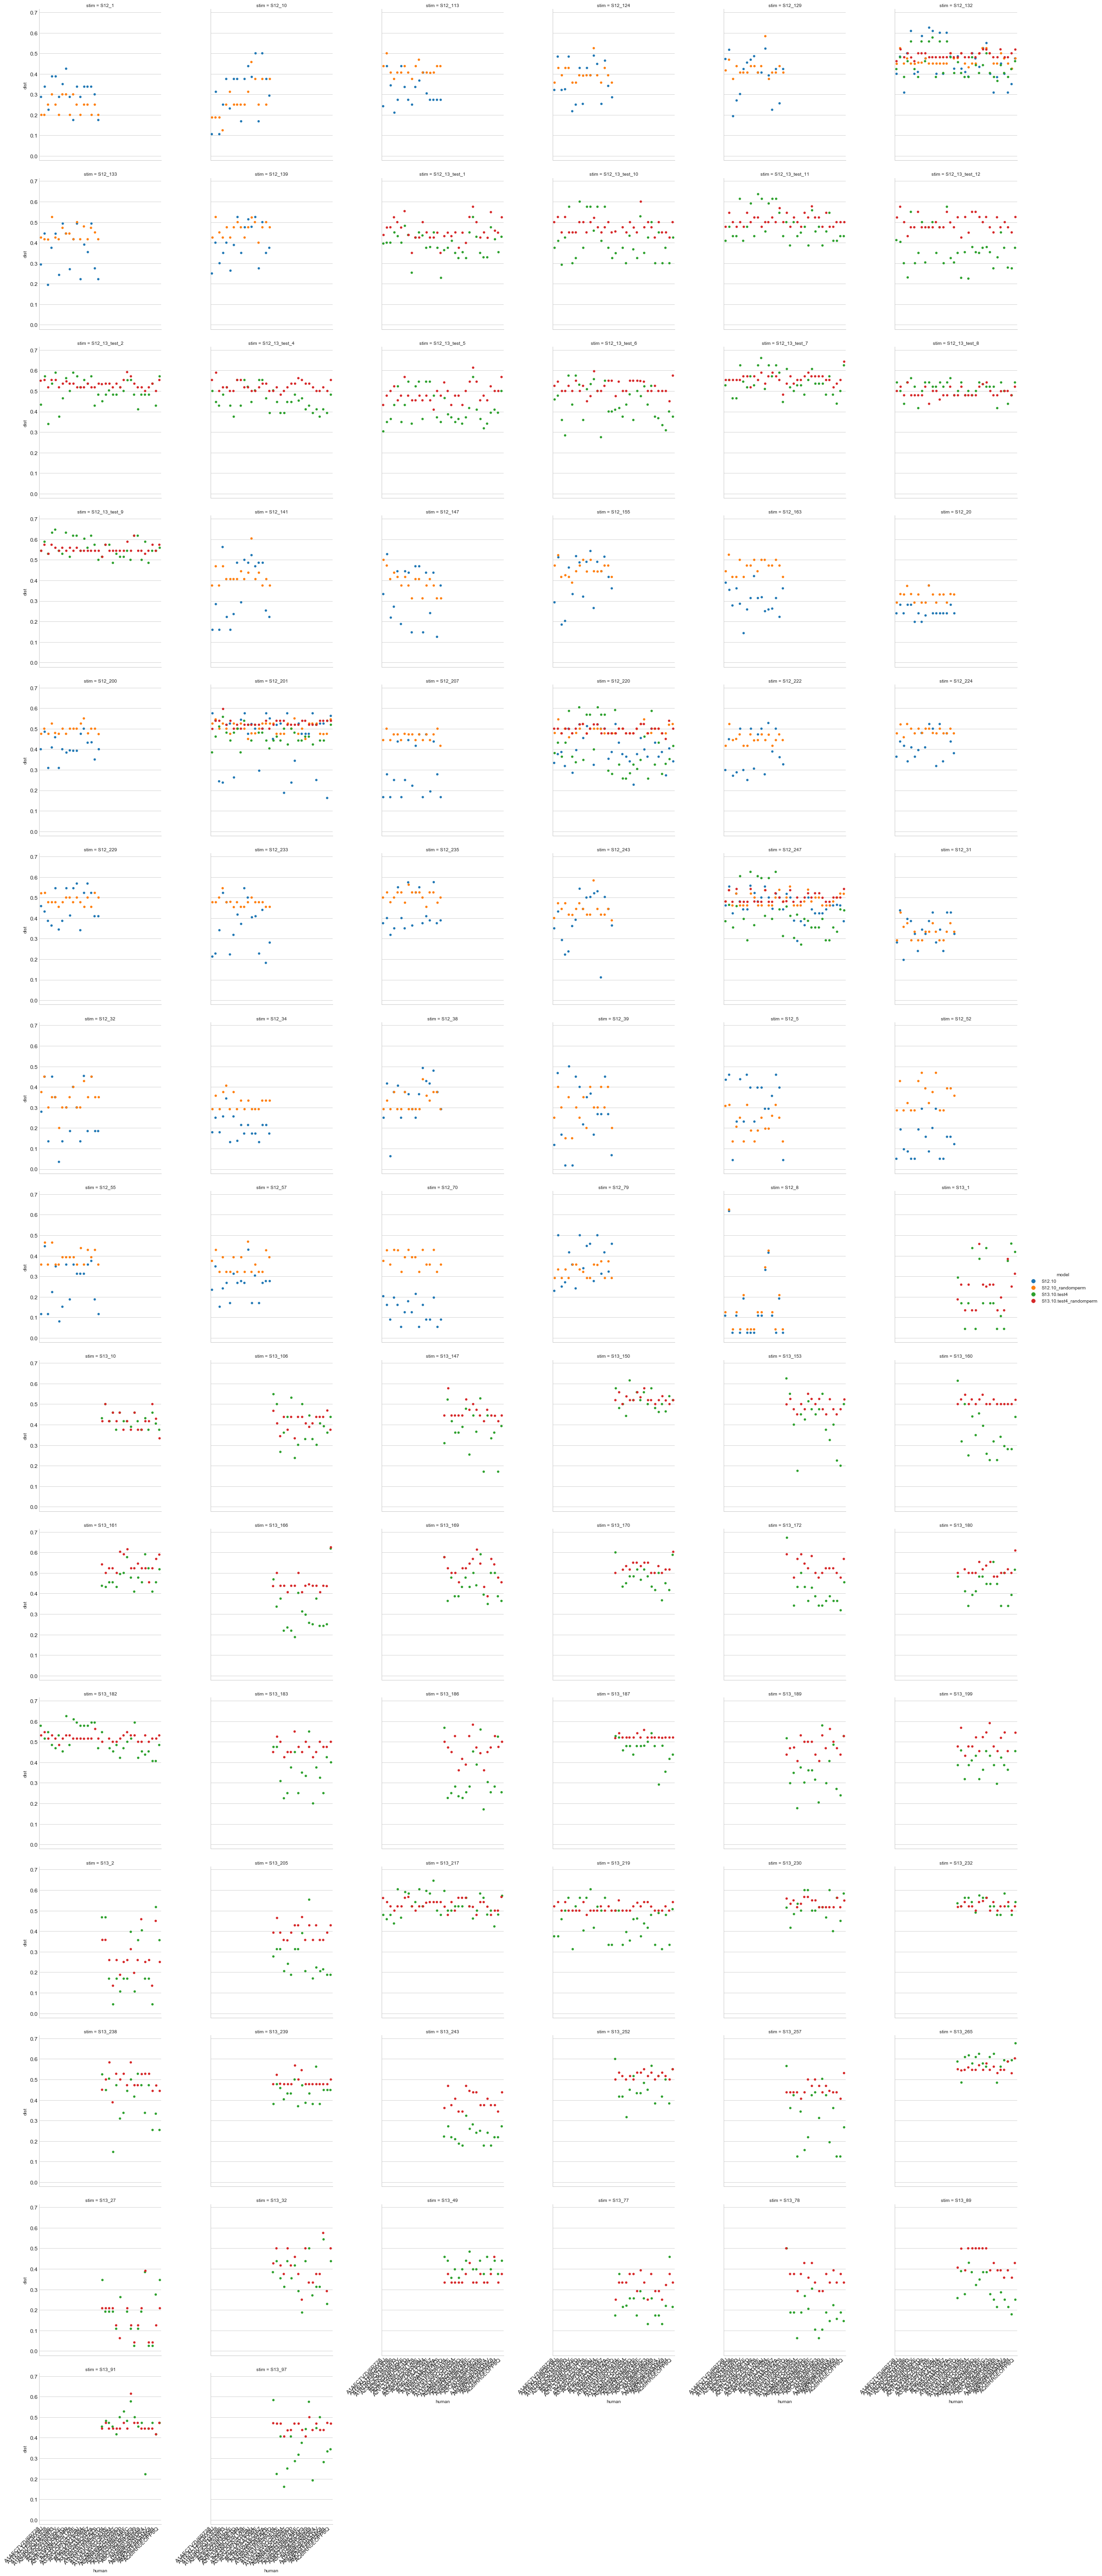

In [7]:
import seaborn as sns

ax = sns.catplot(data=df, hue="model", x="human", y="dist", col="stim", col_wrap=6)
from modelPlanning import addLabel
addLabel(ax)
import os
os.makedirs(SAVEDIR, exist_ok=True)
ax.savefig("{}/overview.pdf".format(SAVEDIR))

In [ ]:
####################################


In [ ]:
## GETTING HUMAN-HUMAN COMPARISONS
# for each stimulus, score distnace between all pairs of humans
